# Trying to implement a unified bi-lingual graph approach to translate word to word english to french

In [ ]:
!pip install datasets
!pip install networkx
!pip install node2vec
!pip install gensim
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 14.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatibl

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

In [ ]:
import csv
import networkx as nx
from datasets import load_dataset
from node2vec import Node2Vec
from gensim.models import Word2Vec
import matplotlib

## Loading the English-French parralel dataset

In [ ]:
dataset = load_dataset("opus_books", "en-fr", split='train[:5000]')

In [ ]:
def preprocess_text(text):
  return [word.lower() for word in text.split() if word.isalpha() and len(word) > 2]

## Build a bilingual graph

In [ ]:
G = nx.Graph()
window_size = 5

num_pairs_to_process = 500
for i, translation_pair in enumerate(dataset):
    if i >= num_pairs_to_process:
        break

    eng_sent = preprocess_text(translation_pair['translation']['en'])
    fr_sent = preprocess_text(translation_pair['translation']['fr'])

    for i, word in enumerate(eng_sent):
        for j in range(max(0, i - window_size), min(len(eng_sent), i + window_size + 1)):
            if i != j:
                G.add_edge(word, eng_sent[j])

    for i, word in enumerate(fr_sent):
        for j in range(max(0, i - window_size), min(len(fr_sent), i + window_size + 1)):
            if i != j:
                G.add_edge(word, fr_sent[j])

    for eng_word in eng_sent:
        for fr_word in fr_sent:
            G.add_edge(eng_word, fr_word)

print(f"Graph created with {G.number_of_nodes()} nodes")
print(f"total nodes and {G.number_of_edges()} edges")

Graph created with 1938 nodes
total nodes and 51724 edges


## Visualizing a Subgraph of the Bilingual Graph
This section visualizes a small portion of the bilingual graph to better understand the connections between words.

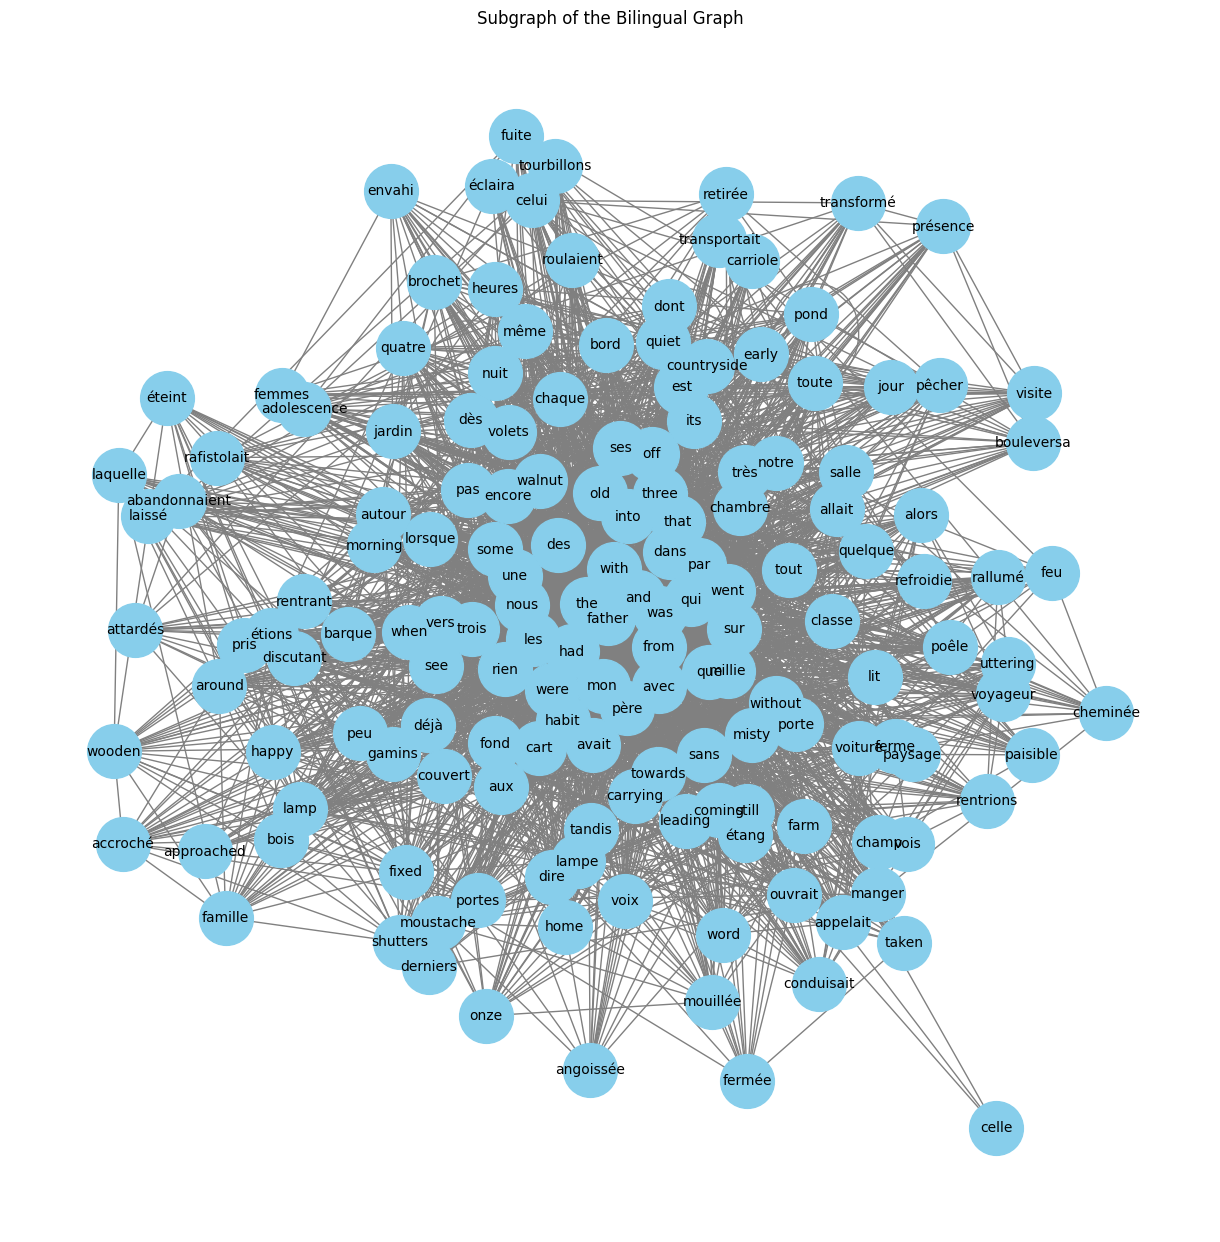

In [ ]:
nodes_to_plot = ['father']

subgraph_nodes = set(nodes_of_interest)
for node in nodes_to_plot:
    if node in G:
        subgraph_nodes.update(G.neighbors(node))

subgraph = G.subgraph(subgraph_nodes)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph, k=1)
nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='gray', linewidths=1, font_size=10)
plt.title("Subgraph of the Bilingual Graph")
plt.show()

##using the node2vec algo on our graph

In [ ]:
node2vec = Node2Vec(G, dimensions=128, walk_length=40, num_walks=100, workers=4, p=1, q=1)
embedding_model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/3390 [00:00<?, ?it/s]

## trying to translate french

In [ ]:
similar_words = embedding_model.wv.most_similar('father', topn=5)
for word, score in similar_words:
  print(f"  - {word}: {score:.4f}")

  - père: 0.8891
  - celle: 0.7213
  - uttering: 0.5906
  - approached: 0.5879
  - accroché: 0.5787


## trying to find the words in english that are similar to livre

In [ ]:
similar_words = embedding_model.wv.most_similar('livre', topn=5)
for word, score in similar_words:
  print(f"  - {word}: {score:.4f}")

  - finiront: 0.9097
  - heads: 0.9019
  - master: 0.9007
  - camarades: 0.8931
  - book: 0.8916


In [ ]:
output_filename = '/content/unified_bilingual_embeddings.kv'
embedding_model.wv.save(output_filename)
print(f"\n✅ Success! Aligned embeddings saved to '{output_filename}'.")


✅ Success! Aligned embeddings saved to '/content/unified_bilingual_embeddings.kv'.
